In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# Load the data
df1 = pd.read_csv("muaBanNhaDat.csv")
df1.head()

In [12]:
def convert_price(price_str):
    if not isinstance(price_str, str):
        # Handle cases where the value is not a string (e.g., NaN or numeric values)
        return np.nan
    try:
        if 'tỷ' in price_str:
            return float(price_str.replace(' tỷ', '').replace(',', '.')) * 1e9
        elif 'triệu' in price_str:
            return float(price_str.replace(' triệu', '').replace(',', '.')) * 1e6
        elif 'nghìn' in price_str:
            return float(price_str.replace(' nghìn', '').replace(',', '.')) * 1e3
        else:
            # Handle cases where the value is already numeric
            return float(price_str.replace(',', '.'))
    except ValueError:
        print(f"ValueError: Could not convert {price_str} to float.")
        return np.nan

In [13]:
import re
# Function to clean and convert room and toilet columns
def clean_rooms_toilets(value):
    if pd.isna(value):
        return 0
    value = str(value).lower()
    # Extract number if the string contains 'nhiều hơn'
    if 'nhiều hơn' in value:
        match = re.search(r'\d+', value)
        if match:
            return int(match.group(0))
    # Clean and convert the value
    return int(value.replace('phòng', '').strip())

In [ ]:
# Load the data
df1 = pd.read_csv("muaBanNhaDat.csv")
df1.head()

df1['urgent'] = df1['title'].apply(lambda x: 'yes' if 'gấp' in x.lower() or 'ngộp' in x.lower() else 'no')

# Handle 'location' column if it exists
if 'address' in df1.columns:
    # Filter out rows where 'address' contains 'Cập nhật'
    df1 = df1[~df1['address'].str.contains('Cập nhật', case=False, na=False)]

    # Split the 'address' into multiple parts based on ', ' and take the last two columns (district and province)
    df1[['ward','district', 'province']] = df1['address'].apply(lambda x: pd.Series(x.split(', ')[-3:]))

    # Remove "Tp " from the beginning of the 'province' column
    df1['province'] = df1['province'].str.replace(r'^Tp\s+', '', regex=True)

    # Drop the 'address' column after splitting
    df1.drop(columns=['address'], inplace=True)

df1 = df1[df1['province'] == "Hồ Chí Minh"]

# Drop rows where price is "Giá thỏa thuận"
df1 = df1[df1['price'] != "Giá thỏa thuận"]

# Apply content to null value
df1['rooms'] = df1['rooms'].apply(clean_rooms_toilets)
df1['toilets'] = df1['toilets'].apply(clean_rooms_toilets)

df1['floors'] = df1['floors'].fillna(0)
df1['house_type'] = df1['house_type'].fillna('no')
df1['pty_characteristics'] = df1['pty_characteristics'].fillna('no')
df1['furnishing_sell'] = df1['furnishing_sell'].fillna('no')
df1['province'] = df1['province'].fillna('')

# Apply conversion functions
df1['price'] = df1['price'].astype(str).apply(convert_price)

# Ensure all values in 'price_m2' are strings before extracting the numeric part
df1['price_m2'] = df1['price_m2'].astype(str)

# Extract numeric value from 'price_m2', convert commas to periods, and convert to float
df1['price_m2'] = df1['price_m2'].str.extract(r'([\d,.]+)').replace(',', '.', regex=True).astype(float)

# Convert 'price' and 'price_m2' to numeric, if not already
df1['price'] = pd.to_numeric(df1['price'], errors='coerce')
df1['price_m2'] = pd.to_numeric(df1['price_m2'], errors='coerce')

# Ensure all values in 'size' are strings before removing 'm²' and converting to float
df1['size'] = df1['size'].astype(str)

# Remove 'm²' and any spaces from 'size', then convert to float
df1['size'] = df1['size'].str.replace(r'm²', '', regex=True).str.strip().astype(float)

# Nếu cột 'size' có giá trị NaN, tính toán lại giá trị cho nó
df1['size'] = df1['size'].fillna(df1['price'] / (df1['price_m2'] * 1000000))

# Làm tròn cột 'size' đến 2 chữ số thập phân
df1['size'] = df1['size'].round(2)

df1.drop(columns=['price_m2'], inplace=True)
df1.drop(columns=['property_legal_document'], inplace=True)
df1.drop(columns=['direction'], inplace=True)
df1.drop(columns=['width'], inplace=True)
df1.drop(columns=['length'], inplace=True)
df1.drop(columns=['living_size'], inplace=True)
df1.drop(columns=['province'], inplace=True)
df1.drop(columns=['title'], inplace=True)


# Display the updated DataFrame
df1.head()


In [ ]:
# Kiểm tra giá trị thiếu
print(df1.isnull().sum())
print(df1.shape)

In [ ]:
# Convert 'price' and 'size' columns to numeric, forcing errors to NaN
df1['price'] = pd.to_numeric(df1['price'], errors='coerce')
df1['size'] = pd.to_numeric(df1['size'], errors='coerce')

# Drop rows where 'price' or 'size' are NaN
df1 = df1.dropna(subset=['price', 'size'])

# Compute IQR for price and size
Q1 = df1[['price', 'size']].quantile(0.25)
Q3 = df1[['price', 'size']].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (df1[['price', 'size']] < (Q1 - 1.5 * IQR)) | (df1[['price', 'size']] > (Q3 + 1.5 * IQR))

# Remove outliers
df1 = df1[~outliers.any(axis=1)]

# Print the shape of the cleaned DataFrame
print("Shape of cleaned DataFrame:")
print(df1.shape)


In [ ]:
print(df1.describe())
df1.shape

In [20]:
df1.to_csv('houseDataset.csv',encoding="utf-8-sig",index=False)

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Bước 1: Đọc dữ liệu
df = pd.read_csv('houseDataset.csv')

# Bước 2: Kiểm Tra và Xử Lý Giá Trị Thiếu
print("Số lượng giá trị thiếu trong mỗi cột:")
print(df.isnull().sum())

# Điền giá trị thiếu cho các cột số
df['size'].fillna(df['size'].mean(), inplace=True)
df['rooms'].fillna(df['rooms'].median(), inplace=True)
df['toilets'].fillna(df['toilets'].median(), inplace=True)
df['floors'].fillna(df['floors'].median(), inplace=True)

# Điền giá trị thiếu cho cột phân loại
df['ward'].fillna(df['ward'].mode()[0], inplace=True)

# Bước 3: Loại Bỏ Bản Ghi Trùng Lặp
duplicates = df.duplicated().sum()
print(f"Số bản ghi trùng lặp: {duplicates}")

# Loại bỏ các bản ghi trùng lặp
df.drop_duplicates(inplace=True)

# Bước 4: Kiểm Tra và Xử Lý Giá Trị Bất Thường
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Loại bỏ outliers
df = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]

df.to_csv('optimized_houseDataset.csv', index=False)

print("Dataset đã được tối ưu và lưu vào 'optimized_houseDataset.csv'.")



Số lượng giá trị thiếu trong mỗi cột:
price                  0
rooms                  0
toilets                0
floors                 0
house_type             0
furnishing_sell        0
size                   0
pty_characteristics    0
urgent                 0
ward                   1
district               0
dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_15780\929983643.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['size'].fillna(df['size'].mean(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15780\929983643.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Số bản ghi trùng lặp: 329
Dataset đã được tối ưu và lưu vào 'optimized_houseDataset.csv'.


              price        rooms      toilets       floors         size
count  5.276000e+03  5276.000000  5276.000000  5276.000000  5276.000000
mean   5.084138e+09     3.187453     2.335671     1.837945    56.114333
std    2.805971e+09     1.460741     1.713981     2.601583    24.583315
min    1.300000e+08     1.000000     0.000000     0.000000     8.000000
25%    2.990000e+09     2.000000     1.000000     0.000000    39.000000
50%    4.850000e+09     3.000000     2.000000     2.000000    54.000000
75%    6.800000e+09     4.000000     3.000000     3.000000    72.000000
max    1.270000e+10    10.000000     6.000000    55.000000   127.300000


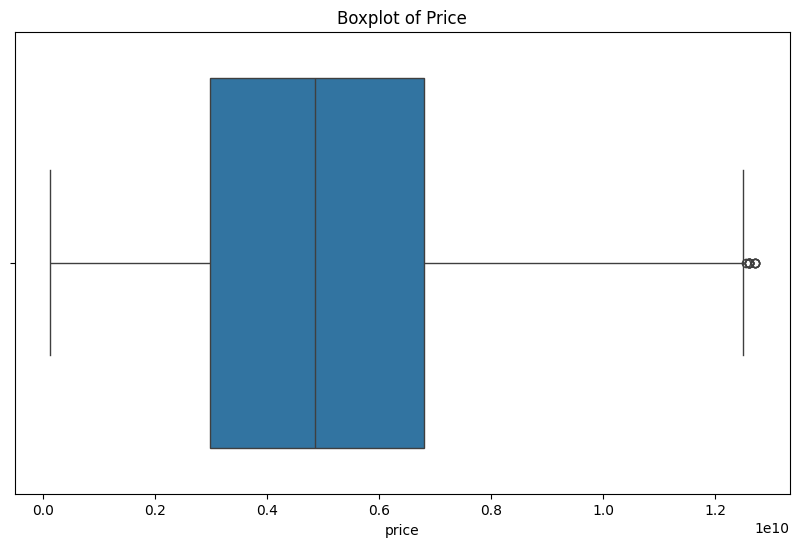

Outliers detected using Z-score:
Empty DataFrame
Columns: [price, rooms, toilets, floors, house_type, furnishing_sell, size, pty_characteristics, urgent, ward, district]
Index: []
Outliers detected using IQR:
             price  rooms  toilets  floors             house_type  \
475   1.255000e+10      5        0     3.0           Nhà ngõ, hẻm   
998   1.270000e+10      6        6     4.0           Nhà ngõ, hẻm   
1035  1.270000e+10      5        5     4.0  Nhà mặt phố, mặt tiền   
1651  1.260000e+10      9        6     0.0  Nhà mặt phố, mặt tiền   
2285  1.270000e+10      8        6     6.0  Nhà mặt phố, mặt tiền   
3005  1.260000e+10      2        2     1.0  Nhà mặt phố, mặt tiền   
3414  1.270000e+10      4        4     4.0  Nhà mặt phố, mặt tiền   
3724  1.260000e+10      4        0     4.0  Nhà mặt phố, mặt tiền   
4464  1.260000e+10      4        3     2.0  Nhà mặt phố, mặt tiền   
4841  1.260000e+10      4        0     0.0           Nhà ngõ, hẻm   
4891  1.260000e+10      4       

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import IsolationForest

# Bước 1: Tải dữ liệu từ file CSV
df = pd.read_csv('optimized_houseDataset.csv')

# Bước 2: Hiển thị thông tin mô tả về dữ liệu
print(df.describe())

# Bước 3: Kiểm tra outliers bằng Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])  # Thay 'price' bằng cột bạn muốn kiểm tra
plt.title('Boxplot of Price')
plt.show()

# Bước 4: Kiểm tra outliers bằng Z-score
z_scores = np.abs(stats.zscore(df['price']))  # Thay 'price' bằng cột bạn muốn kiểm tra
outliers_z = df[z_scores > 3]  # Chọn các giá trị ngoại lệ
print("Outliers detected using Z-score:")
print(outliers_z)

# Bước 5: Kiểm tra outliers bằng IQR
Q1 = df['price'].quantile(0.25)  # Thay 'price' bằng cột bạn muốn kiểm tra
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]  # Thay 'price' bằng cột bạn muốn kiểm tra
print("Outliers detected using IQR:")
print(outliers_iqr)

# Bước 6: Kiểm tra outliers bằng Isolation Forest
model = IsolationForest(contamination=0.01)  # Giả định 1% là outliers
model.fit(df[['price']])  # Thay 'price' bằng cột bạn muốn kiểm tra
df['outlier'] = model.predict(df[['price']])

# Lọc các giá trị ngoại lệ
outliers_iforest = df[df['outlier'] == -1]  # -1 chỉ ra là outlier
print("Outliers detected using Isolation Forest:")
print(outliers_iforest)

# Bước 7: Xử lý outliers (Tùy chọn)
# Ví dụ: loại bỏ outliers
df_cleaned = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
# hoặc thay thế bằng trung vị
# median_price = df['price'].median()
# df['price'] = np.where(df['price'] > upper_bound, median_price, df['price'])

# Bước 8: Hiển thị thông tin về dữ liệu sau khi xử lý
print("Data after removing outliers:")
print(df_cleaned.describe())


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Bước 1: Tải dữ liệu từ file CSV
df = pd.read_csv('optimized_houseDataset.csv')

# Bước 2: Chuẩn bị dữ liệu (chọn các cột cần thiết)
X_categorical = df[['ward', 'district', 'house_type', 'furnishing_sell', 'urgent', 'pty_characteristics']]
X_numeric = df[['size', 'rooms', 'toilets', 'floors']]
y = df['price']  # Cột giá nhà làm biến mục tiêu

# Bước 3: Encode các biến phân loại (One-Hot Encoding)
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_features = encoder.fit_transform(X_categorical)

# Kết hợp các đặc trưng đã mã hóa với các biến số
X = np.hstack((encoded_features.toarray(), X_numeric.values))

# Bước 4: Chia tập dữ liệu thành tập huấn luyện và kiểm tra (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Hồi Quy Tuyến Tính
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(f'Linear Regression - Mean Absolute Error (MAE): {mae_lr:,.0f} VND')
print(f'Linear Regression - Mean Squared Error (MSE): {mse_lr:,.0f} VND^2')
print(f'Linear Regression - Root Mean Squared Error (RMSE): {rmse_lr:,.0f} VND\n')

# 2. Hồi Quy Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

print(f'Ridge Regression - Mean Absolute Error (MAE): {mae_ridge:,.0f} VND')
print(f'Ridge Regression - Mean Squared Error (MSE): {mse_ridge:,.0f} VND^2')
print(f'Ridge Regression - Root Mean Squared Error (RMSE): {rmse_ridge:,.0f} VND\n')

# 3. Hồi Quy Lasso
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)

print(f'Lasso Regression - Mean Absolute Error (MAE): {mae_lasso:,.0f} VND')
print(f'Lasso Regression - Mean Squared Error (MSE): {mse_lasso:,.0f} VND^2')
print(f'Lasso Regression - Root Mean Squared Error (RMSE): {rmse_lasso:,.0f} VND\n')

# 4. Hồi Quy Cây Quyết Định
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)

print(f'Decision Tree Regression - Mean Absolute Error (MAE): {mae_tree:,.0f} VND')
print(f'Decision Tree Regression - Mean Squared Error (MSE): {mse_tree:,.0f} VND^2')
print(f'Decision Tree Regression - Root Mean Squared Error (RMSE): {rmse_tree:,.0f} VND\n')

# 5. Hồi Quy Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f'Random Forest Regression - Mean Absolute Error (MAE): {mae_rf:,.0f} VND')
print(f'Random Forest Regression - Mean Squared Error (MSE): {mse_rf:,.0f} VND^2')
print(f'Random Forest Regression - Root Mean Squared Error (RMSE): {rmse_rf:,.0f} VND')



Linear Regression - Mean Absolute Error (MAE): 17,376,612,478,387,242 VND
Linear Regression - Mean Squared Error (MSE): 90,455,571,999,541,261,492,272,978,229,985,280 VND^2
Linear Regression - Root Mean Squared Error (RMSE): 300,758,328,229,728,768 VND

Ridge Regression - Mean Absolute Error (MAE): 1,127,123,468 VND
Ridge Regression - Mean Squared Error (MSE): 2,313,108,375,933,410,816 VND^2
Ridge Regression - Root Mean Squared Error (RMSE): 1,520,890,652 VND



d:\Workspace python\RealEstatePredict\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.538e+21, tolerance: 3.290e+18
  model = cd_fast.enet_coordinate_descent(


Lasso Regression - Mean Absolute Error (MAE): 1,134,771,549 VND
Lasso Regression - Mean Squared Error (MSE): 2,353,023,664,634,495,488 VND^2
Lasso Regression - Root Mean Squared Error (RMSE): 1,533,956,865 VND

Decision Tree Regression - Mean Absolute Error (MAE): 1,290,773,674 VND
Decision Tree Regression - Mean Squared Error (MSE): 3,602,158,892,992,423,936 VND^2
Decision Tree Regression - Root Mean Squared Error (RMSE): 1,897,935,429 VND

Random Forest Regression - Mean Absolute Error (MAE): 985,523,203 VND
Random Forest Regression - Mean Squared Error (MSE): 1,947,889,882,242,038,784 VND^2
Random Forest Regression - Root Mean Squared Error (RMSE): 1,395,668,257 VND


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Bước 1: Tải dữ liệu từ file CSV
df = pd.read_csv('houseDataset.csv')

# Bước 2: Mã hóa các biến phân loại bằng Label Encoding (nếu cần)
# Bạn có thể chuyển đổi các biến phân loại thành số (Label Encoding) nếu chưa làm
from sklearn.preprocessing import LabelEncoder

# Các cột phân loại cần mã hóa
categorical_cols = ['ward', 'district', 'house_type', 'furnishing_sell', 'pty_characteristics', 'urgent']

# Mã hóa từng cột phân loại
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Bước 3: Tính ma trận tương quan giữa các biến
corr_matrix = df.corr()

# Bước 4: Vẽ biểu đồ heatmap để trực quan hóa ma trận tương quan
plt.figure(figsize=(12, 8))  # Kích thước biểu đồ
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Tùy chỉnh tiêu đề
plt.title('Correlation Heatmap of Features', fontsize=16)

# Hiển thị biểu đồ
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load dataset
df = pd.read_csv('houseDataset.csv')

# Loại bỏ các ngoại lệ dựa trên IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Encode các đặc trưng phân loại
encoder = OneHotEncoder(sparse_output=False)
categorical_features = ['ward','district', 'house_type', 'furnishing_sell']
encoded_features = encoder.fit_transform(df[categorical_features])

# Tạo DataFrame cho các đặc trưng đã mã hóa
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Kết hợp các đặc trưng mã hóa với các đặc trưng số học
X = pd.concat([encoded_df, df[['size', 'rooms', 'toilets', 'floors']].reset_index(drop=True)], axis=1)
y = df['price']

# Chuẩn hóa các đặc trưng số học
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia tập dữ liệu thành training và testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Khởi tạo các mô hình
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Tạo danh sách để lưu trữ kết quả
results = []

# Huấn luyện và đánh giá từng mô hình
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append({'Model': name, 'R2 Score': r2, 'MSE': mse})
    print(f"{name} - R² Score: {r2:.2f}, MSE: {mse:,.2f}")

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)

# Hiển thị bảng kết quả
print("\nKết quả đánh giá các mô hình:")
print(results_df)

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Load dataset
df = pd.read_csv('houseDataset.csv')

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
categorical_features = ['ward', 'district', 'house_type', 'furnishing_sell', 'urgent', "pty_characteristics"]
encoded_features = encoder.fit_transform(df[categorical_features])

# Create DataFrame for encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Combine encoded features with numerical features
X = pd.concat([encoded_df, df[['size', 'rooms', 'toilets', 'floors']].reset_index(drop=True)], axis=1)
y = df['price']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Predict the price of a new house
new_house = pd.DataFrame({
    'ward': ['Phường 14'],
    'district': ['Quận 3'],
    'size': [56],
    'rooms': [6],
    'toilets': [6],
    'floors': [3],
    'house_type': ['Nhà ngõ, hẻm'],
    'furnishing_sell': ['Hoàn thiện cơ bản'],
    'urgent': ['no'],
    'pty_characteristics': ['Hẻm xe hơi'],
})

# Encode the new house data
encoded_new_house = encoder.transform(new_house[['ward', 'district', 'house_type', 'furnishing_sell', 'urgent', "pty_characteristics"]])
new_house_features = np.hstack((encoded_new_house, new_house[['size', 'rooms', 'toilets', 'floors']].values))

# Predict the price of the new house using Random Forest model
predicted_price = random_forest_model.predict(new_house_features)
print(f"Giá nhà dự đoán bằng Random Forest: {predicted_price[0]:,.0f} VND")


Giá nhà dự đoán bằng Random Forest: 9,729,100,000 VND


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

df = pd.read_csv('optimized_houseDataset.csv')

# Assuming df is already prepared
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['ward', 'district', 'house_type', 'furnishing_sell', 'urgent', "pty_characteristics"]])

# Combine encoded features with numeric features
X = np.hstack((encoded_features.toarray(), df[['size', 'rooms', 'toilets', 'floors']].values))
y = df['price']

# Train the model
model = LinearRegression()
model.fit(X, y)

# Create a DataFrame for the new house
new_house = pd.DataFrame({
'ward': ['Phường 14'],
'district': ['Quận 3'],
'size': [56],
'rooms': [6],
'toilets': [6],
'floors': [3],
'house_type': ['Nhà ngõ, hẻm'],
'furnishing_sell': ['Hoàn thiện cơ bản'],
'urgent': ['yes'],
'pty_characteristics': ['Hẻm xe hơi'],
})

# Encode the new house data
encoded_new_house = encoder.transform(new_house[['ward', 'district', 'house_type', 'furnishing_sell', 'urgent', "pty_characteristics"]]).toarray()
new_house_features = np.hstack((encoded_new_house, new_house[['size', 'rooms', 'toilets', 'floors']].values))

# Dự đoán giá nhà mới bằng mô hình Random Forest
predicted_price = model.predict(new_house_features)
print(f"Giá nhà dự đoán bằng Linear Regression: {predicted_price[0]:,.0f} VND")

Giá nhà dự đoán bằng Linear Regression: 7,788,535,808 VND


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor

# Tải dữ liệu
df = pd.read_csv('houseDataset.csv')

# Giả định df đã được chuẩn bị
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['ward', 'district', 'house_type', 'furnishing_sell', 'status']])

# Kết hợp các đặc trưng đã mã hóa với các đặc trưng số học
X = np.hstack((encoded_features.toarray(), df[['size', 'rooms', 'toilets', 'floors']].values))
y = df['price']

# Huấn luyện mô hình Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X, y)

# Tạo DataFrame cho nhà mới
new_house = pd.DataFrame({
'ward': ['Phường 2'],
'district': ['Quận 5'],
'size': [52],
'rooms': [3],
'toilets': [2],
'floors': [2],
'house_type': ['Nhà ngõ, hẻm'],
'furnishing_sell': ['Nội thất đầy đủ'],
'status': ['yes'],
})

# Mã hóa dữ liệu nhà mới
encoded_new_house = encoder.transform(new_house[['ward', 'district', 'house_type', 'furnishing_sell', 'status']]).toarray()
new_house_features = np.hstack((encoded_new_house, new_house[['size', 'rooms', 'toilets', 'floors']].values))

# Dự đoán giá nhà mới bằng mô hình Gradient Boosting
predicted_price = model.predict(new_house_features)
print(f"Giá nhà dự đoán bằng Gradient Boosting: {predicted_price[0]:,.0f} VND")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

# Tải dữ liệu
df = pd.read_csv('houseDataset.csv')

# Giả định df đã được chuẩn bị
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['ward', 'district', 'house_type', 'furnishing_sell']])

# Kết hợp các đặc trưng đã mã hóa với các đặc trưng số học
X = np.hstack((encoded_features.toarray(), df[['size', 'rooms', 'toilets', 'floors']].values))
y = df['price']

# Huấn luyện mô hình Ridge Regression
model = Ridge(alpha=1.0)  # alpha là tham số điều chỉnh
model.fit(X, y)

# Tạo DataFrame cho nhà mới
new_house = pd.DataFrame({
'ward': ['Phường 2'],
'district': ['Quận 5'],
'size': [52],
'rooms': [3],
'toilets': [2],
'floors': [2],
'house_type': ['Nhà ngõ, hẻm'],
'furnishing_sell': ['Nội thất đầy đủ'],
})

# Mã hóa dữ liệu nhà mới
encoded_new_house = encoder.transform(new_house[['ward', 'district', 'house_type', 'furnishing_sell']]).toarray()
new_house_features = np.hstack((encoded_new_house, new_house[['size', 'rooms', 'toilets', 'floors']].values))

# Dự đoán giá nhà mới bằng mô hình Ridge Regression
predicted_price = model.predict(new_house_features)
print(f"Giá nhà dự đoán bằng Ridge Regression: {predicted_price[0]:,.0f} VND")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso

# Tải dữ liệu
df = pd.read_csv('houseDataset.csv')

# Giả định df đã được chuẩn bị
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['ward', 'district', 'house_type', 'furnishing_sell']])

# Kết hợp các đặc trưng đã mã hóa với các đặc trưng số học
X = np.hstack((encoded_features.toarray(), df[['size', 'rooms', 'toilets', 'floors']].values))
y = df['price']

# Huấn luyện mô hình Lasso Regression
model = Lasso(alpha=0.1)  # alpha là tham số điều chỉnh
model.fit(X, y)

# Tạo DataFrame cho nhà mới
new_house = pd.DataFrame({
'ward': ['Phường 2'],
'district': ['Quận 5'],
'size': [52],
'rooms': [3],
'toilets': [2],
'floors': [2],
'house_type': ['Nhà ngõ, hẻm'],
'furnishing_sell': ['Nội thất đầy đủ'],
})

# Mã hóa dữ liệu nhà mới
encoded_new_house = encoder.transform(new_house[['ward', 'district', 'house_type', 'furnishing_sell']]).toarray()
new_house_features = np.hstack((encoded_new_house, new_house[['size', 'rooms', 'toilets', 'floors']].values))

# Dự đoán giá nhà mới bằng mô hình Lasso Regression
predicted_price = model.predict(new_house_features)
print(f"Giá nhà dự đoán bằng Lasso Regression: {predicted_price[0]:,.0f} VND")
